# Create figures for GSWP3 atmospheric forcing
Plots to visualize some of the model inputs for atmospheric forcing from GSWP3, i.e., the dataset providing climatic observations driving model processes such as photosynthesis or evaporation.

<span style="color:red;">This notebook requires model input data, which is automatically downloaded after creating a case through the NorESM-LSP GUI.</span>

After specifying the path to a case's `data/` folder below, run all cells in this notebook. The most convenient way is clicking the "⏩" button contained in the navigation bar at the top. It will create image files called `atmosphere_[variable_name].png` in a folder with the given case name in this working directory - i.e., either a new folder `/notebooks/plot_input_data/[case_id]/` will appear or the files will be added to it if it already exists. Click the folder icon in the navigation bar to the left if JupyterLab currently does not display the File Browser. Feel free to adapt the code in this notebook according to your needs.

In [1]:
from pathlib import Path

# Add the full case name in quotation marks here! E.g.: "7733d6a59846cb18c051d598e968f695_alp1"
case_id = "c6f7f22a0872ca464bc471135fb69021_test2"

# Path to input data. Only change this line if you renamed the folder or moved it from the default location!
inputdata_path = Path(f"../../data/{case_id}/")

In [2]:
# Enter the case's site code in quotation marks here! E.g.: "BOR1".
# ATTENTION! This is case sensitive, use the correct capitalization of letters!
site_code = "TST2"
# If you are unsure about the site code, you can try to uncomment the next two lines instead
#import glob
#site_code = Path(glob.glob(f"../../data/{case_id}/domain*.nc")[0]).name.split("_")[2]

In the cell below, you can specify custom start and end dates for plotting a short time period with the original CLM5-GSWP3 temporal resolution, i.e. in 3 hourly timesteps. It shouldn't be longer than a year to maintain readability. Changing the time period can be useful if you have observational data that you roughly want to compare to the default inputs. The plots give you an idea which atmospheric data is needed for running the CLM in land-only mode - you could integrate your own observations for specialized experiments.

In [3]:
# WARNING! Must be between 1901-01-01 and 2013-12-31!
subset_time_start = '2013-01-01'  # Format: YYYY-MM-DD
subset_time_end = '2013-12-31'  # Format: YYYY-MM-DD

<span style="color: red;">Warning!</span> The following code is written for the NorESM-LSP version 1.0 default atmospheric forcing, i.e. the GSWP3 dataset. If you provide different forcing data or changed the default save locations you need to adjust the scripts accordingly.

_No code cells below need to be altered unless you desire custom changes._

---

In [4]:
import matplotlib.pyplot as plt
import xarray as xr
import time
import glob

In [5]:
# Root path to surface data
atm_forcing_data_path = Path(f"{inputdata_path}/datmdata/")

In [6]:
# open and combine all the monthly atmospheric NetCDF files present in the folder into an xarray dataset
# Should take approx. 8-10 minutes
start_time = time.time()

climate_data_file_paths = glob.glob(f"{atm_forcing_data_path}/*TPQWL*.nc") \
+ glob.glob(f"{atm_forcing_data_path}/*Solr*.nc") \
+ glob.glob(f"{atm_forcing_data_path}/*Prec*.nc")


atm_forcing_data = xr.open_mfdataset(climate_data_file_paths, 
                                     decode_times=True
                                    )
print(f"--- Time it took to read the data: {round(float(time.time() - start_time), 3)} seconds ---")

--- Time it took to read the data: 248.82 seconds ---


In [7]:
# Create case folder for output plots if necessary
out_dir_path = Path().absolute() / case_id

if not out_dir_path.is_dir():
    out_dir_path.mkdir(parents=True, exist_ok=True)

In [8]:
# Set general plotting options
DPI = 150
TICK_LABEL_FONT_SIZE = 12
AX_LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16

## Full dataset period

In [9]:
# Print dataset info
atm_forcing_data

<xarray.Dataset>
Dimensions:   (lon: 1, lat: 1, time: 665760, scalar: 1)
Coordinates:
  * lon       (lon) float32 227.8
  * lat       (lat) float32 62.25
  * time      (time) object 1901-01-01 00:00:00 ... 2014-12-31 22:30:00
Dimensions without coordinates: scalar
Data variables: (12/13)
    LONGXY    (time, lat, lon) float32 dask.array<chunksize=(496, 1, 1), meta=np.ndarray>
    LATIXY    (time, lat, lon) float32 dask.array<chunksize=(496, 1, 1), meta=np.ndarray>
    EDGEE     (time, scalar, lat, lon) float32 dask.array<chunksize=(496, 1, 1, 1), meta=np.ndarray>
    EDGEW     (time, scalar, lat, lon) float32 dask.array<chunksize=(496, 1, 1, 1), meta=np.ndarray>
    EDGES     (time, scalar, lat, lon) float32 dask.array<chunksize=(496, 1, 1, 1), meta=np.ndarray>
    EDGEN     (time, scalar, lat, lon) float32 dask.array<chunksize=(496, 1, 1, 1), meta=np.ndarray>
    ...        ...
    TBOT      (time, lat, lon) float32 dask.array<chunksize=(497, 1, 1), meta=np.ndarray>
    WIND      (time, lat, lon) float32 dask.array<chunksize=(497, 1, 1), meta=np.ndarray>
    QBOT      (time, lat, lon) float32 dask.array<chunksize=(497, 1, 1), meta=np.ndarray>
    FLDS      (time, lat, lon) float32 dask.array<chunksize=(497, 1, 1), meta=np.ndarray>
    FSDS      (time, lat, lon) float32 dask.array<chunksize=(496, 1, 1), meta=np.ndarray>
    PRECTmms  (time, lat, lon) float32 dask.array<chunksize=(497, 1, 1), meta=np.ndarray>
Attributes:
    case_title:    GSWP3 3-Hourly Atmospheric Forcing: Temperature, Pressure,...
    Created_on:    2022-10-31
    Created_by:    kavehka
    Created_with:  ./subset_data -- 97f34c975
    Created_from:  /cluster/shared/noresm/inputdata/atm/datm7/atm_forcing.dat...

#### Annual temperature, precipitation, and total incident solar radiation
The code cells below illustrate how the `xarray` and `matplotlib` libraries can be used for input data wrangling and plotting.

In [10]:
# Temperature, resample to annual mean, convert from K to °C
temp_mean_year = atm_forcing_data["TBOT"].resample(time='1Y').mean() - 273.15

# Precipitation, convert from [mm H2O / sec] to total (3h=10800s model time step), resample to annual sum
precip_total_year = (atm_forcing_data["PRECTmms"] * 10800).resample(time='1Y').sum()

# Radiation, resample to annual mean
radiation_mean_year = atm_forcing_data["FSDS"].resample(time='1Y').mean()

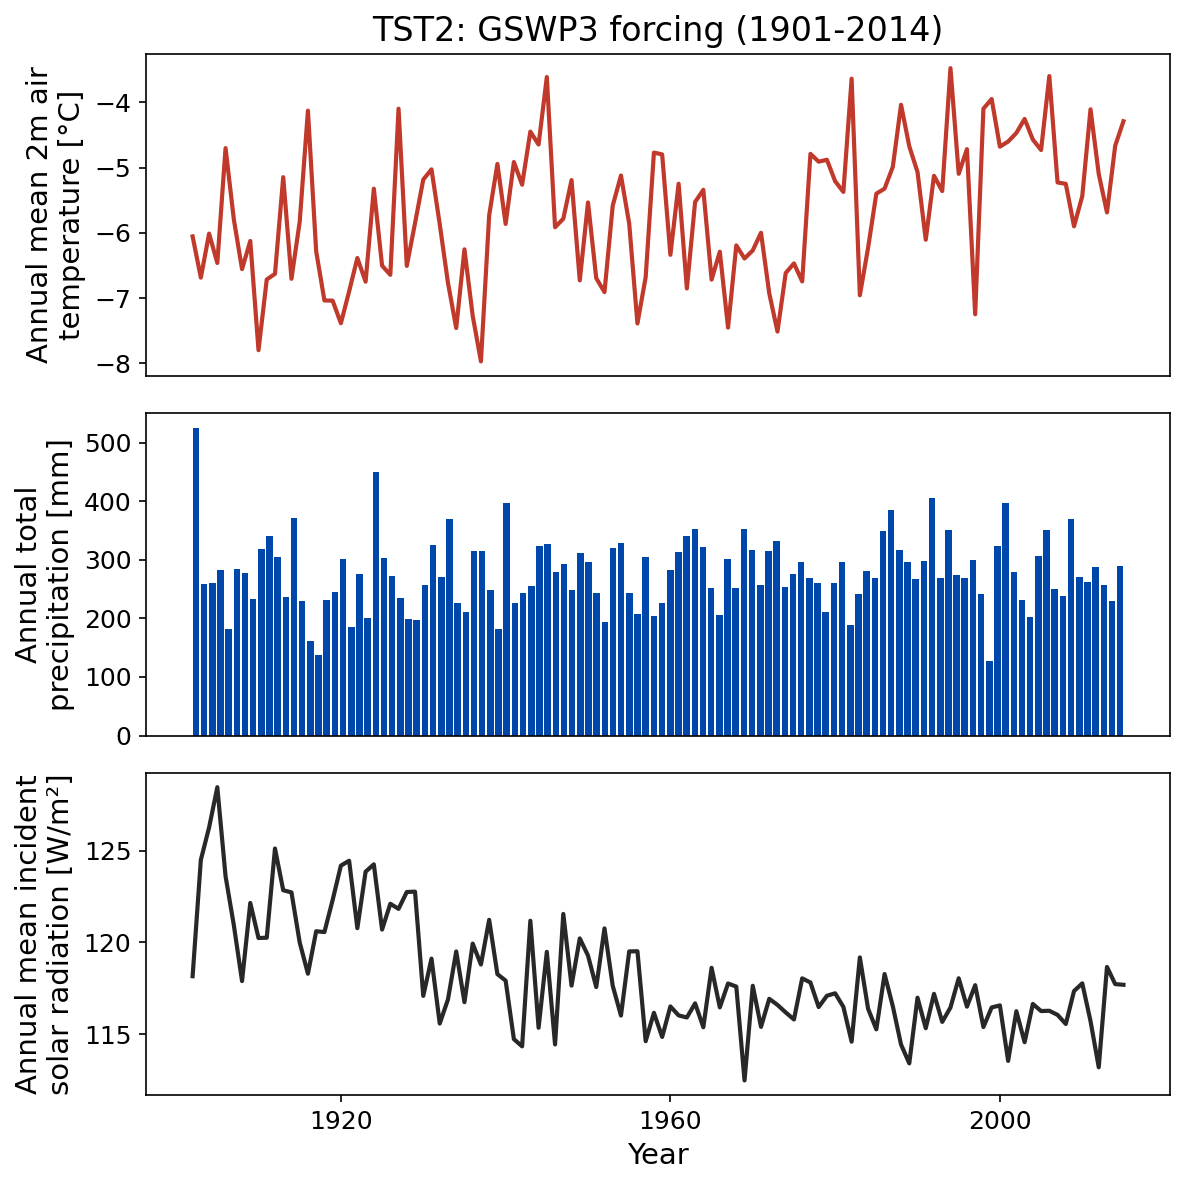

In [17]:
# Instantiate plot, one subplot for each variable
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,
                                    figsize=(8, 8),
                                    dpi=DPI)

ax1.plot(range(len(temp_mean_year.time)),
         temp_mean_year.values.flatten(),
         color="#C0392B",
         linewidth=2,
         label="Annual mean temperature [°C]"
       )

ax2.bar(x=range(len(precip_total_year.time)),
        height=precip_total_year.values.flatten(),
        color="#0047AB",
        label="Total precipitation"
       )

ax3.plot(radiation_mean_year.time,
         radiation_mean_year.values.flatten(),
         color="#28282B",
         linewidth=2,
         label="Annual mean incident solar radiation [W/m²]"
        )

# Disable x axes for subplots 1 and 2
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)

# Other plot layout settings
ax1.set_title(f"{site_code}: GSWP3 forcing (1901-2014)", size=TITLE_FONT_SIZE)

ax1.set_ylabel("Annual mean 2m air\ntemperature [°C]", fontsize=AX_LABEL_FONT_SIZE)
ax2.set_ylabel("Annual total\nprecipitation [mm]", fontsize=AX_LABEL_FONT_SIZE)
ax3.set_ylabel("Annual mean incident\nsolar radiation [W/m²]", fontsize=AX_LABEL_FONT_SIZE)
ax3.set_xlabel("Year", fontsize=AX_LABEL_FONT_SIZE)

ax1.tick_params(axis='y', which='major', labelsize=TICK_LABEL_FONT_SIZE)
ax2.tick_params(axis='y', which='major', labelsize=TICK_LABEL_FONT_SIZE)
ax3.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{out_dir_path}/atmosphere_yearly_temp_precip_rad.png", format='png')

---
## Short period

In [12]:
atm_forcing_data

<xarray.Dataset>
Dimensions:   (lon: 1, lat: 1, time: 665760, scalar: 1)
Coordinates:
  * lon       (lon) float32 227.8
  * lat       (lat) float32 62.25
  * time      (time) object 1901-01-01 00:00:00 ... 2014-12-31 22:30:00
Dimensions without coordinates: scalar
Data variables: (12/13)
    LONGXY    (time, lat, lon) float32 dask.array<chunksize=(496, 1, 1), meta=np.ndarray>
    LATIXY    (time, lat, lon) float32 dask.array<chunksize=(496, 1, 1), meta=np.ndarray>
    EDGEE     (time, scalar, lat, lon) float32 dask.array<chunksize=(496, 1, 1, 1), meta=np.ndarray>
    EDGEW     (time, scalar, lat, lon) float32 dask.array<chunksize=(496, 1, 1, 1), meta=np.ndarray>
    EDGES     (time, scalar, lat, lon) float32 dask.array<chunksize=(496, 1, 1, 1), meta=np.ndarray>
    EDGEN     (time, scalar, lat, lon) float32 dask.array<chunksize=(496, 1, 1, 1), meta=np.ndarray>
    ...        ...
    TBOT      (time, lat, lon) float32 dask.array<chunksize=(497, 1, 1), meta=np.ndarray>
    WIND      (time, lat, lon) float32 dask.array<chunksize=(497, 1, 1), meta=np.ndarray>
    QBOT      (time, lat, lon) float32 dask.array<chunksize=(497, 1, 1), meta=np.ndarray>
    FLDS      (time, lat, lon) float32 dask.array<chunksize=(497, 1, 1), meta=np.ndarray>
    FSDS      (time, lat, lon) float32 dask.array<chunksize=(496, 1, 1), meta=np.ndarray>
    PRECTmms  (time, lat, lon) float32 dask.array<chunksize=(497, 1, 1), meta=np.ndarray>
Attributes:
    case_title:    GSWP3 3-Hourly Atmospheric Forcing: Temperature, Pressure,...
    Created_on:    2022-10-31
    Created_by:    kavehka
    Created_with:  ./subset_data -- 97f34c975
    Created_from:  /cluster/shared/noresm/inputdata/atm/datm7/atm_forcing.dat...

### Temperature, precipitation, total radiation, longwave radiation, humidity, wind, atm. pressure 

In [13]:
atm_forcing_subset = atm_forcing_data.sel(
    time=slice(subset_time_start, subset_time_end)
)
atm_forcing_subset

<xarray.Dataset>
Dimensions:   (lon: 1, lat: 1, time: 5840, scalar: 1)
Coordinates:
  * lon       (lon) float32 227.8
  * lat       (lat) float32 62.25
  * time      (time) object 2013-01-01 00:00:00 ... 2013-12-31 22:30:00
Dimensions without coordinates: scalar
Data variables: (12/13)
    LONGXY    (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    LATIXY    (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    EDGEE     (time, scalar, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    EDGEW     (time, scalar, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    EDGES     (time, scalar, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    EDGEN     (time, scalar, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    ...        ...
    TBOT      (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    WIND      (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    QBOT      (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    FLDS      (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    FSDS      (time, lat, lon) float32 dask.array<chunksize=(496, 1, 1), meta=np.ndarray>
    PRECTmms  (time, lat, lon) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes:
    case_title:    GSWP3 3-Hourly Atmospheric Forcing: Temperature, Pressure,...
    Created_on:    2022-10-31
    Created_by:    kavehka
    Created_with:  ./subset_data -- 97f34c975
    Created_from:  /cluster/shared/noresm/inputdata/atm/datm7/atm_forcing.dat...

In [14]:
variable_list = []

# Temperature, convert from K to °C
temp_subset = (atm_forcing_subset["TBOT"] - 273.15).dropna(dim="time")
variable_list.append(temp_subset)

# Precipitation, convert from [mm H2O / sec] to total [mm] (data temp. resolution: 3h=10800s), calculate cumulative sum
precip_subset = (atm_forcing_subset["PRECTmms"] * 10800).cumsum().dropna(dim="time")
variable_list.append(precip_subset)

# Total incident radiation
radation_total_subset = atm_forcing_subset["FSDS"].dropna(dim="time")
variable_list.append(radation_total_subset)

# Incident longwave radiation
radation_longwave_subset = atm_forcing_subset["FLDS"].dropna(dim="time")
variable_list.append(radation_longwave_subset)

# Specific humidity
humidity_subset = atm_forcing_subset["QBOT"].dropna(dim="time")
variable_list.append(humidity_subset)

# Wind speed
wind_subset = atm_forcing_subset["WIND"].dropna(dim="time")
variable_list.append(wind_subset)

# Atm. pressure, convert to hPa
pressure_subset = (atm_forcing_subset["PSRF"] * 0.01).dropna(dim="time")
variable_list.append(pressure_subset)

In [15]:
# Label dictionary
subset_plot_dict = {
    "TBOT": {
        "y_axis": "2m air temperature",
        "unit": "[°C]",
        "color": "#C0392B",
    },
    "PRECTmms": {
        "y_axis": "Cumulative precipitation",
        "unit": "[mm]",
        "color": "#0047AB",
    },
    "FSDS": {
        "y_axis": "Total incident solar radiation",
        "unit": "[W/m²]",
        "color": "#28282B",
    },
    "FLDS": {
        "y_axis": "Incident longwave radiation",
        "unit": "[W/m²]",
        "color": "#FE5654",
    },
    "QBOT": {
        "y_axis": "2m specific humidity",
        "unit": "[kg/kg]",
        "color": "#8EA9F6",
    },
    "WIND": {
        "y_axis": "2m wind speed",
        "unit": "[m/s]",
        "color": "#F00BF3",
    },
    "PSRF": {
        "y_axis": "Surface pressure",
        "unit": "[hPa]",
        "color": "#6B6B6B",
    },
}

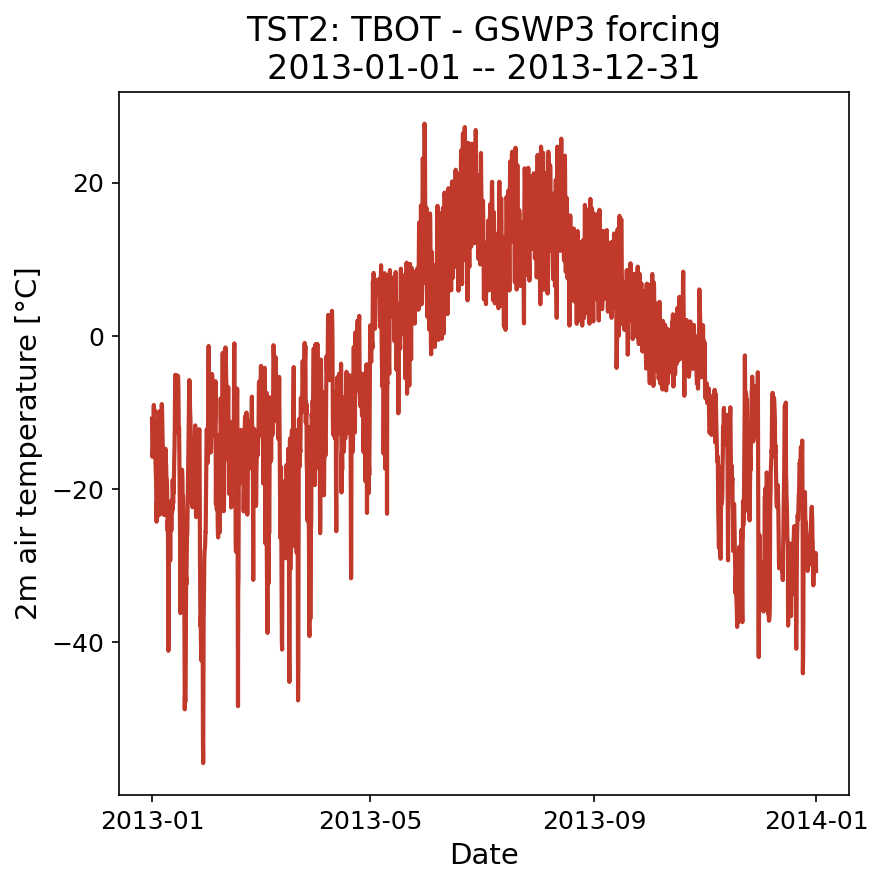

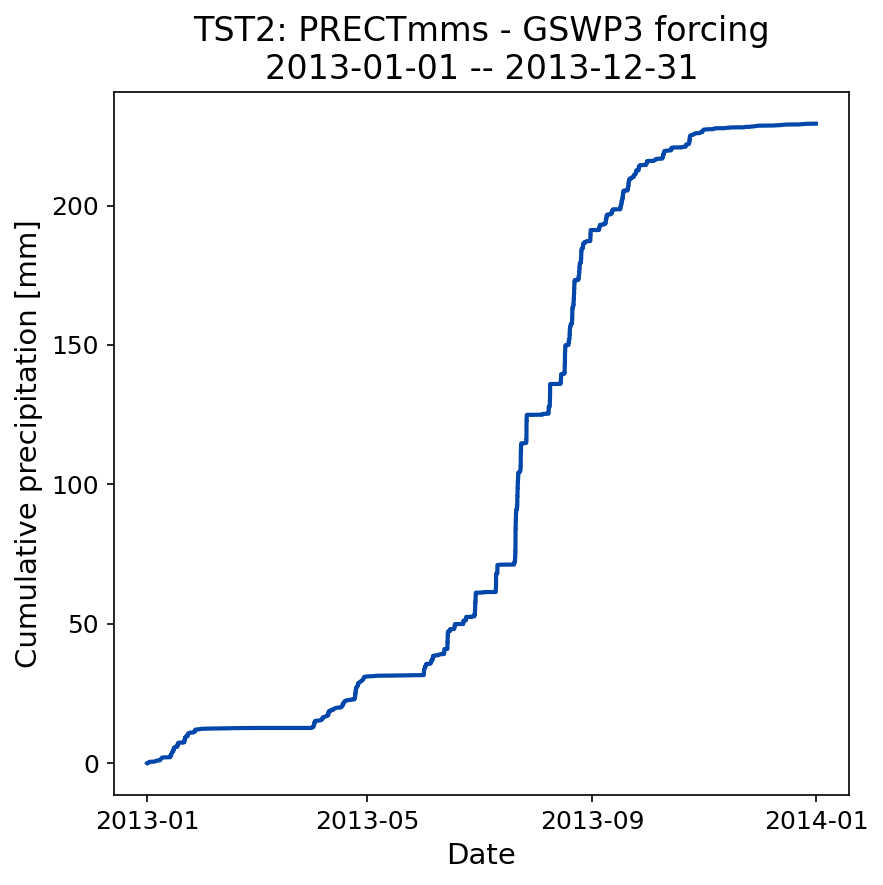

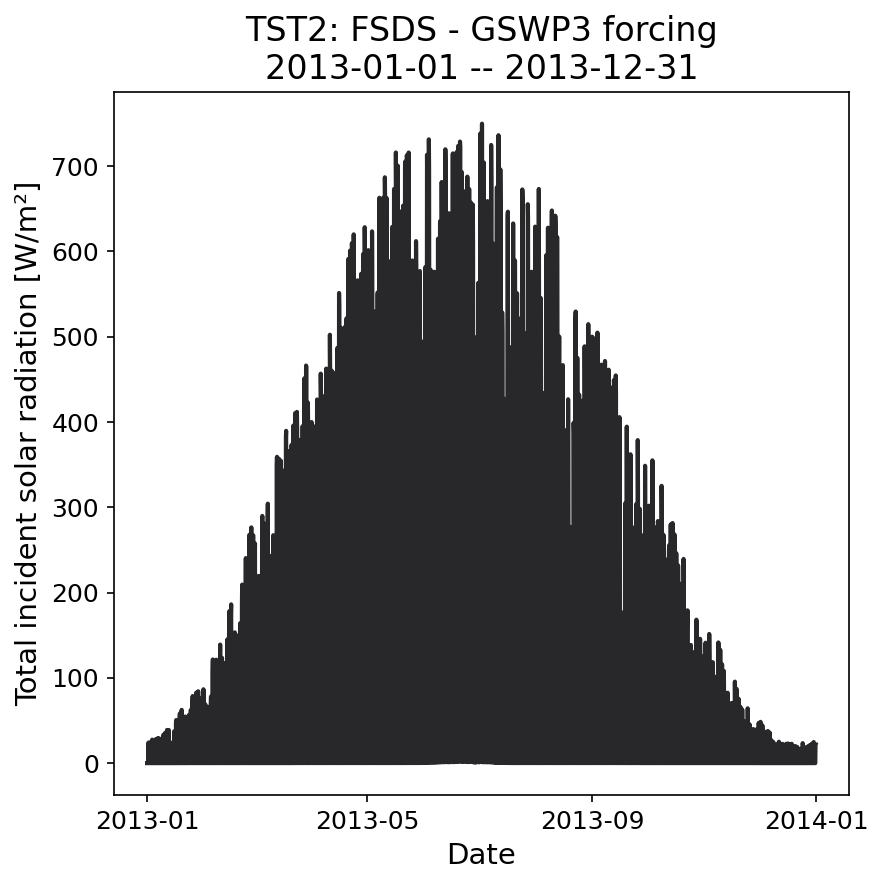

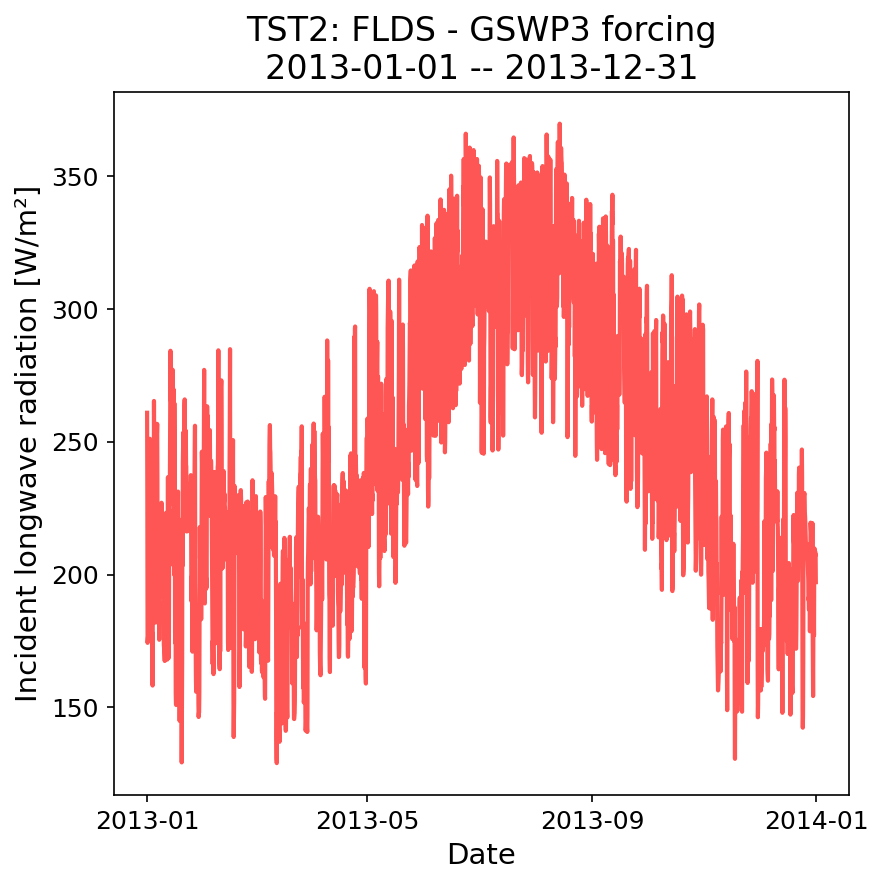

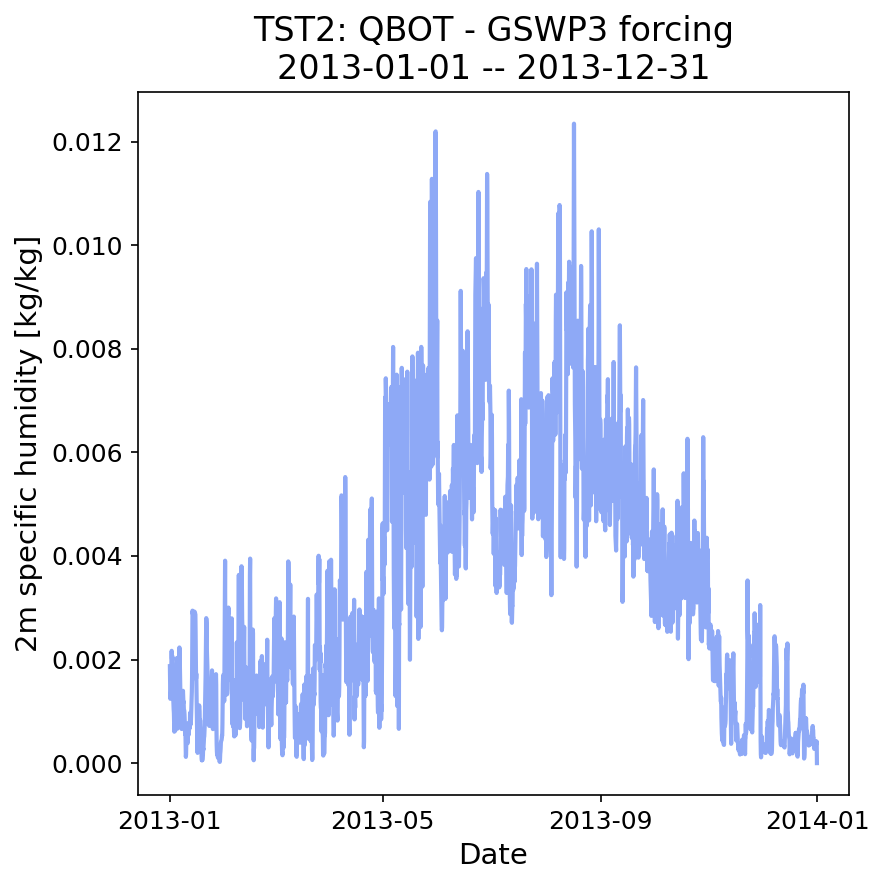

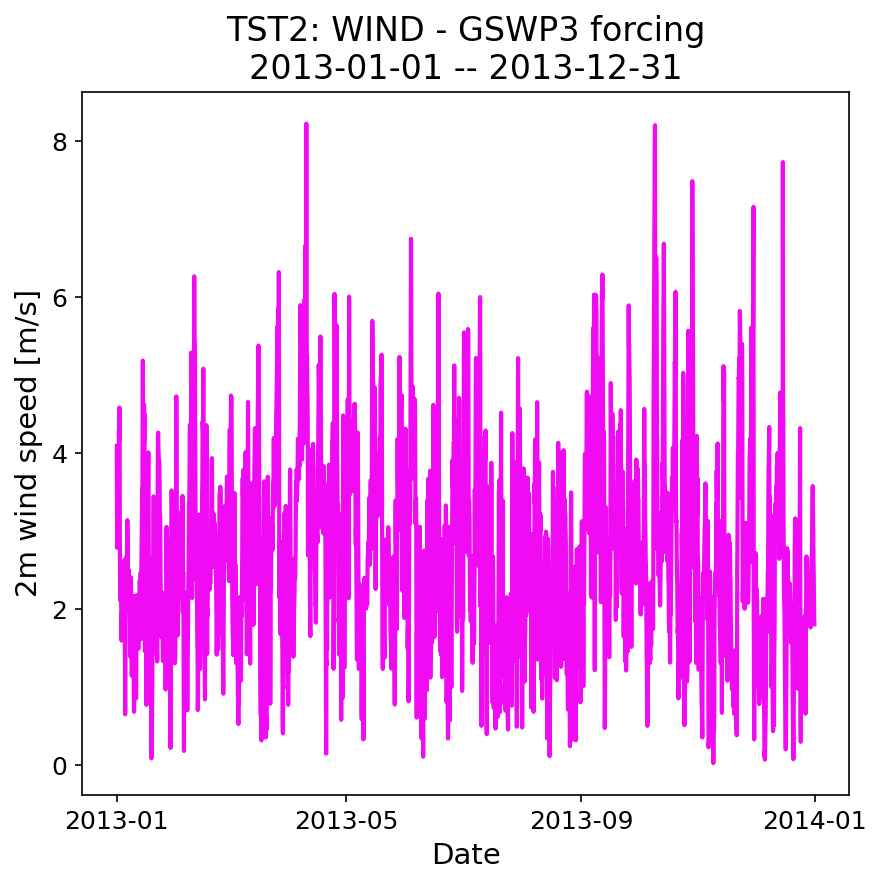

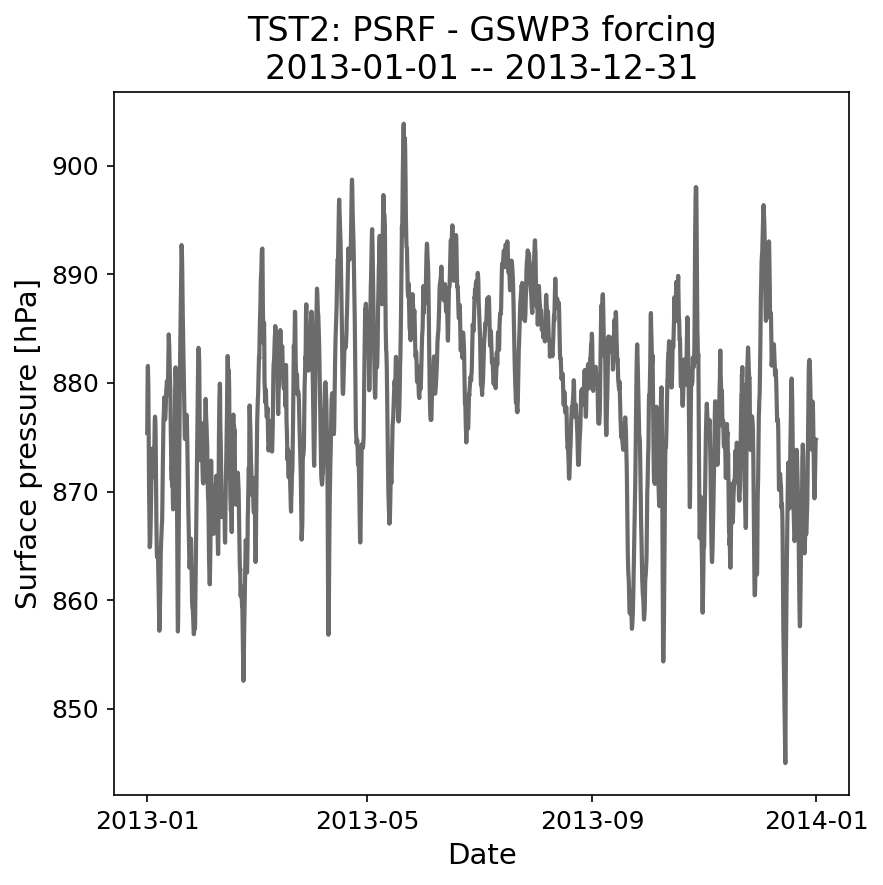

In [16]:
# Create plots for each variable
for variable in variable_list:
    
    # Get plot settings for current variable
    current_var_dict = subset_plot_dict.get(variable.name)
    
    # Instantiate plot
    fig, ax = plt.subplots(figsize=(6, 6), dpi=DPI)

    ax.plot(variable.time,
            variable.values.flatten(),
            color=current_var_dict.get('color'),
            linewidth=2,
           )
    
    # Other plot layout settings
    ax.set_title(f"{site_code}: {variable.name} - GSWP3 forcing\n{subset_time_start} -- {subset_time_end}", size=TITLE_FONT_SIZE)

    ax.set_ylabel(current_var_dict.get('y_axis') + " " + current_var_dict.get('unit'),
                  fontsize=AX_LABEL_FONT_SIZE)
    ax.set_xlabel("Date", fontsize=AX_LABEL_FONT_SIZE)

    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)

    # Save figure
    fig.tight_layout()
    fig.savefig(fname=f"{out_dir_path}/atmosphere_{variable.name}_{subset_time_start}_to_{subset_time_end}.png", format='png')